In [51]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import time
import pickle
import os
from scipy import stats

import anndata as ad
import scanpy as sc
import episcanpy as epi

plt.rcParams["figure.figsize"]= (4, 4)

In [52]:
import scipy
scipy.__version__

'1.13.0'

In [53]:
import sys
print(sys. version)

3.12.3 | packaged by conda-forge | (main, Apr 15 2024, 18:38:13) [GCC 12.3.0]


# Load the data

In [54]:
df = pd.read_csv('WIM13335_PD24_SwissMouse_perc_PrecDet_int_top3av_ratio_TTEST_Peptides (1).csv',
                sep=';')
df

,Checked,Confidence,Annotated Sequence,Modifications,Qvality PEP,Qvality q-value,# Protein Groups,# Proteins,# PSMs,Master Protein Accessions,...,"Found in Sample: [S8] F8: Sample, VPR","Found in Sample: [S9] F9: Sample, VPR","Found in Sample: [S10] F10: Sample, VPR","Found in Sample: [S11] F11: Sample, VPR","Found in Sample: [S12] F12: Sample, VPR",Confidence (by Search Engine): Sequest HT,Percolator q-Value (by Search Engine): Sequest HT,Percolator PEP (by Search Engine): Sequest HT,XCorr (by Search Engine): Sequest HT,Top Apex RT [min]
0,False,High,[R].GTSFEAAATSGGSASSEK.[A],NaN,"8,50702E-06","0,000037994",1,1,34,Q99LC5,...,High,High,High,High,High,High,"0,00000692","6,024E-15","2,94","31,55"
1,False,High,[R].KSDIYVCMISYAHNVAAQGK.[Y],1xCarbamidomethyl [C7],"1,47813E-05","0,000037994",1,1,2,P50396,...,High,Not Found,High,Not Found,Not Found,High,"0,00000692","2,007E-13","2,17",NaN
2,False,High,[R].KSDIYVCMISFAHNVAAQGK.[Y],1xCarbamidomethyl [C7],"1,516E-08","0,000037994",1,1,5,Q61598,...,High,Peak Found,High,Peak Found,Peak Found,High,"0,00000692","6,305E-16","3,45","89,25"
3,False,High,[R].KSDLFQDDLYPDTAGPEAALEAEEWFEGK.[N],NaN,"1,55548E-09","0,000037994",1,1,10,Q9WUM4,...,High,High,High,High,High,High,"0,00000692","6,305E-16","5,47","100,99"
4,False,High,[K].KSDIDEIVLVGGSTR.[I],NaN,"1,01436E-07","0,000037994",1,1,37,P20029,...,High,High,High,High,High,High,"0,00000692","6,305E-16","3,44","64,47"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50527,False,High,[K].LEEVMAQLEEEK.[K],1xOxidation [M5],"0,151933","0,00998909",1,1,1,B9EJA2,...,Not Found,Not Found,Not Found,Not Found,Not Found,High,"0,002176","0,03323","1,14",NaN
50528,False,High,[K].LEHEYIQNFK.[I],1xDeamidated [Q7],"0,151933","0,00998909",1,1,1,Q61166,...,Not Found,Not Found,Not Found,High,Not Found,High,"0,002176","0,0334","1,06",NaN
50529,False,High,[R].AASEAGGPAR.[L],NaN,"0,151933","0,00998909",1,1,1,P35569,...,Peak Found,High,Peak Found,Peak Found,Peak Found,High,"0,002176","0,03329","0,96","26,72"
50530,False,High,[R].YQFDPNLGIR.[Q],NaN,"0,151933","0,00998909",1,1,3,Q6PDI5,...,Peak Found,Peak Found,High,High,Peak Found,High,"0,002176","0,03331","1,54","70,15"


In [55]:
gtf_file = "gencode.vM35.chr_patch_hapl_scaff.annotation.gtf"
df1 = pd.read_csv(gtf_file, skiprows=5, header=None, sep='\t')
df1 = df1[df1[2]=='transcript'].copy()

ensmust = []
gene_name = []
for line in df1[8].tolist():
    line= line.split(';')
    ensmust_current="NA"
    gene_name_current="NA"
    for element in line : 
        if 'transcript_id' in element:
            ensmust_current = element.split('"')[-2]
        elif 'gene_name' in element:
            gene_name_current =  element.split('"')[-2]
    if gene_name != 'NA':
        ensmust.append(ensmust_current)
        gene_name.append(gene_name_current)

df2 = pd.DataFrame()
df2['ENSMUST']=ensmust
df2['gene name']=gene_name
df2.index=df2['ENSMUST'].tolist()


###############

prot_file='gencode.vM35.metadata.SwissProt'
df3 = pd.read_csv(prot_file, header=None, sep='\t')
df3.index = df3[0].tolist()
df3.columns=['ensembl_id', 'uniprot_label', 'unitprot_label2']

###############

df_names = df2.merge(df3, left_index=True, right_index=True)
df_names.index = df_names['uniprot_label'].tolist()
df_names

,ENSMUST,gene name,ensembl_id,uniprot_label,unitprot_label2
Q5GH67,ENSMUST00000070533.5,Xkr4,ENSMUST00000070533.5,Q5GH67,Q5GH67.111
P56716,ENSMUST00000027032.6,Rp1,ENSMUST00000027032.6,P56716,P56716.144
Q61473,ENSMUST00000027035.10,Sox17,ENSMUST00000027035.10,Q61473,Q61473.180
Q61473,ENSMUST00000195555.2,Sox17,ENSMUST00000195555.2,Q61473,Q61473.180
Q61473,ENSMUST00000116652.8,Sox17,ENSMUST00000116652.8,Q61473,Q61473.180
...,...,...,...,...,...
P03903,ENSMUST00000084013.1,mt-Nd4l,ENSMUST00000084013.1,P03903,P03903.143
P03911,ENSMUST00000082414.1,mt-Nd4,ENSMUST00000082414.1,P03911,P03911.160
P03921,ENSMUST00000082418.1,mt-Nd5,ENSMUST00000082418.1,P03921,P03921.152
P03925,ENSMUST00000082419.1,mt-Nd6,ENSMUST00000082419.1,P03925,P03925.137


In [56]:
gene_name = []
missing_gene_names = []

for prot in df['Master Protein Accessions'].tolist():
    
    if prot not in df_names.index.tolist():
        #print(prot)
        gene_name.append('missing protein name')
        missing_gene_names.append(prot)
    elif type(df_names.loc[prot]['gene name']) ==str:
        gene_name.append(df_names.loc[prot]['gene name'])
    else:
        gene_name.append(df_names.loc[prot]['gene name'].tolist()[0])
len(set(gene_name))
df['gene_name'] = gene_name

# Format the dataframe to fit with the AnnData data structure

In [57]:
samples = ['Abundances (Normalized): F1: Sample, noVPR',
       'Abundances (Normalized): F2: Sample, noVPR',
       'Abundances (Normalized): F3: Sample, noVPR',
       'Abundances (Normalized): F4: Sample, noVPR',
       'Abundances (Normalized): F5: Sample, noVPR',
       'Abundances (Normalized): F6: Sample, noVPR',
       'Abundances (Normalized): F7: Sample, VPR',
       'Abundances (Normalized): F8: Sample, VPR',
       'Abundances (Normalized): F9: Sample, VPR',
       'Abundances (Normalized): F10: Sample, VPR',
       'Abundances (Normalized): F11: Sample, VPR',
       'Abundances (Normalized): F12: Sample, VPR']

df2 = df[samples]
df2

for column in df2.columns:
    df2[column] = [float('.'.join(str(x).split(','))) for x in df2[column].tolist()]

samples2 = ['Abundances Count: F1: Sample, noVPR',
       'Abundances Count: F2: Sample, noVPR',
       'Abundances Count: F3: Sample, noVPR',
       'Abundances Count: F4: Sample, noVPR',
       'Abundances Count: F5: Sample, noVPR',
       'Abundances Count: F6: Sample, noVPR',
       'Abundances Count: F7: Sample, VPR',
       'Abundances Count: F8: Sample, VPR',
       'Abundances Count: F9: Sample, VPR',
       'Abundances Count: F10: Sample, VPR',
       'Abundances Count: F11: Sample, VPR',
       'Abundances Count: F12: Sample, VPR']

df3 = df[samples2]
df3

for column in df3.columns:
    df3[column] = [float('.'.join(str(x).split(','))) for x in df3[column].tolist()]

samples2 = ['Abundance: F1: Sample, noVPR', 'Abundance: F2: Sample, noVPR',
       'Abundance: F3: Sample, noVPR', 'Abundance: F4: Sample, noVPR',
       'Abundance: F5: Sample, noVPR', 'Abundance: F6: Sample, noVPR',
       'Abundance: F7: Sample, VPR', 'Abundance: F8: Sample, VPR',
       'Abundance: F9: Sample, VPR', 'Abundance: F10: Sample, VPR',
       'Abundance: F11: Sample, VPR', 'Abundance: F12: Sample, VPR']

df4 = df[samples2]
df4

for column in df4.columns:
    df4[column] = [float('.'.join(str(x).split(','))) for x in df4[column].tolist()]

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [58]:
meta = ['Annotated Sequence', 'Modifications',
       'Qvality PEP', 'Qvality q-value', '# Protein Groups', '# Proteins',
       '# PSMs', 'Master Protein Accessions', 'Positions in Master Proteins',
       'Modifications in Master Proteins', '# Missed Cleavages',
       'Theo. MH+ [Da]', 'Abundance Ratio: (VPR) / (noVPR)', 'gene_name']

adata =ad.AnnData(df2).transpose()
adata.var_names=df['Master Protein Accessions'].tolist()
adata.var=df[meta]
adata.layers['raw_counts']=np.array(df3).transpose()
adata.layers['raw_counts_2']=np.array(df4).transpose()
adata.X = np.nan_to_num(adata.X)
adata.layers['raw_counts'] = np.nan_to_num(adata.layers['raw_counts'])
adata.layers['raw_counts_2'] = np.nan_to_num(adata.layers['raw_counts_2'])
adata.obs['VPR_condition'] =['noVPR']*6+['VPR']*6
adata.obs['replicates'] = ['R1', 'R2', 'R3', 'R4', 'R5', 'R6']+['R1', 'R2', 'R3', 'R4', 'R5', 'R6']

adata

AnnData object with n_obs × n_vars = 12 × 50532
    obs: 'VPR_condition', 'replicates'
    var: 'Annotated Sequence', 'Modifications', 'Qvality PEP', 'Qvality q-value', '# Protein Groups', '# Proteins', '# PSMs', 'Master Protein Accessions', 'Positions in Master Proteins', 'Modifications in Master Proteins', '# Missed Cleavages', 'Theo. MH+ [Da]', 'Abundance Ratio: (VPR) / (noVPR)', 'gene_name'
    layers: 'raw_counts', 'raw_counts_2'

# Filtering and QC

In [59]:
epi.pp.qc_stats(adata, verbose=True)
#sc.pl.violin(adata.transpose(), keys='n_cells')
adata.var['n_samples'] = adata.var['n_cells']
del adata.var['n_cells']

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


added keys n_cells, log_n_cells to .var
added keys n_features, log_n_features, n_counts, log_n_counts to .obs


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user

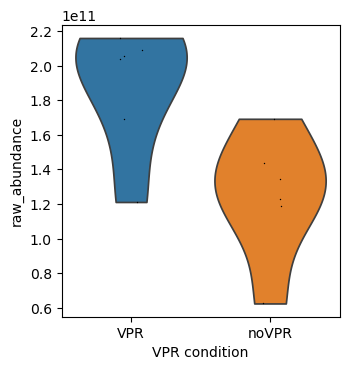

<Axes: xlabel='VPR_condition', ylabel='raw_abundance'>

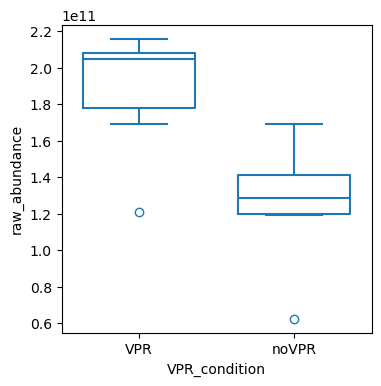

In [60]:
#sc.pl.violin(adata, 'n_counts', groupby='VPR_condition')
#sns.boxplot(data=adata.obs, x="VPR_condition", y="n_counts", fill=False, gap=.1)

adata.obs['raw_abundance'] = np.sum(adata.layers['raw_counts_2'], axis=1).tolist()
sc.pl.violin(adata, 'raw_abundance', groupby='VPR_condition')
sns.boxplot(data=adata.obs, x="VPR_condition", y="raw_abundance", fill=False, gap=.1)

### Welch test comparing the raw peptide abundance between VPR and no VPR conditions

In [61]:
VPR_abundance = adata.obs['raw_abundance'][:6]
noVPR_abundance = adata.obs['raw_abundance'][6:]
stats.ttest_ind(VPR_abundance, noVPR_abundance)

TtestResult(statistic=-2.9899929411855077, pvalue=0.013573821271008889, df=10.0)

# Filter out peptides and get protein level quantification

In [62]:
adata

AnnData object with n_obs × n_vars = 12 × 50532
    obs: 'VPR_condition', 'replicates', 'n_features', 'log_n_features', 'n_counts', 'log_n_counts', 'raw_abundance'
    var: 'Annotated Sequence', 'Modifications', 'Qvality PEP', 'Qvality q-value', '# Protein Groups', '# Proteins', '# PSMs', 'Master Protein Accessions', 'Positions in Master Proteins', 'Modifications in Master Proteins', '# Missed Cleavages', 'Theo. MH+ [Da]', 'Abundance Ratio: (VPR) / (noVPR)', 'gene_name', 'log_n_cells', 'n_samples'
    uns: 'VPR_condition_colors'
    layers: 'raw_counts', 'raw_counts_2'

### tag the peptides that are assigned to more than one protein 

In [63]:
nb_peptides=[]
for line in adata.var['Master Protein Accessions'].tolist():
    if type(line)==float:
        nb_peptides.append(0)
    else:
        line = line.split(';')
        nb_peptides.append(len(line))

### So there is 2 peptides not assigned to any proteins
### There is 50532 different peptides
### There is 1555 peptides assigned to more than one protein

In [64]:
### So now, we remove the peptides assigned to no proteins
adata.var['nb_peptides'] = nb_peptides
adata = adata[:,adata.var['nb_peptides']>0].copy()
adata

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


AnnData object with n_obs × n_vars = 12 × 50530
    obs: 'VPR_condition', 'replicates', 'n_features', 'log_n_features', 'n_counts', 'log_n_counts', 'raw_abundance'
    var: 'Annotated Sequence', 'Modifications', 'Qvality PEP', 'Qvality q-value', '# Protein Groups', '# Proteins', '# PSMs', 'Master Protein Accessions', 'Positions in Master Proteins', 'Modifications in Master Proteins', '# Missed Cleavages', 'Theo. MH+ [Da]', 'Abundance Ratio: (VPR) / (noVPR)', 'gene_name', 'log_n_cells', 'n_samples', 'nb_peptides'
    uns: 'VPR_condition_colors'
    layers: 'raw_counts', 'raw_counts_2'

In [65]:
### Now we want to know for each protein how many peptide there is... 
# But for now I will only consider peptides assigned to a single protein

In [66]:
adata = adata[:,adata.var['nb_peptides']==1].copy()
adata

AnnData object with n_obs × n_vars = 12 × 48975
    obs: 'VPR_condition', 'replicates', 'n_features', 'log_n_features', 'n_counts', 'log_n_counts', 'raw_abundance'
    var: 'Annotated Sequence', 'Modifications', 'Qvality PEP', 'Qvality q-value', '# Protein Groups', '# Proteins', '# PSMs', 'Master Protein Accessions', 'Positions in Master Proteins', 'Modifications in Master Proteins', '# Missed Cleavages', 'Theo. MH+ [Da]', 'Abundance Ratio: (VPR) / (noVPR)', 'gene_name', 'log_n_cells', 'n_samples', 'nb_peptides'
    uns: 'VPR_condition_colors'
    layers: 'raw_counts', 'raw_counts_2'

In [67]:
list_prot = []
prot_pep_count = []
dict_prot = {}
for prot in set(adata.var['Master Protein Accessions']):
    list_prot.append(prot)
    dict_prot[prot]= adata.var['Master Protein Accessions'].tolist().count(prot)
    prot_pep_count.append(adata.var['Master Protein Accessions'].tolist().count(prot))


label = []
for prot in adata.var['Master Protein Accessions'].tolist():
    label.append(dict_prot[prot])
adata.var['nb_peptide_for_prot'] = label

In [68]:
# remove peptides detected in less than 3 samples
adata = adata[:,adata.var['n_samples']>=3].copy()
adata

AnnData object with n_obs × n_vars = 12 × 40406
    obs: 'VPR_condition', 'replicates', 'n_features', 'log_n_features', 'n_counts', 'log_n_counts', 'raw_abundance'
    var: 'Annotated Sequence', 'Modifications', 'Qvality PEP', 'Qvality q-value', '# Protein Groups', '# Proteins', '# PSMs', 'Master Protein Accessions', 'Positions in Master Proteins', 'Modifications in Master Proteins', '# Missed Cleavages', 'Theo. MH+ [Da]', 'Abundance Ratio: (VPR) / (noVPR)', 'gene_name', 'log_n_cells', 'n_samples', 'nb_peptides', 'nb_peptide_for_prot'
    uns: 'VPR_condition_colors'
    layers: 'raw_counts', 'raw_counts_2'

In [69]:
# remove proteins with less then 2 peptides measured
adata = adata[:,adata.var['nb_peptide_for_prot']>=2].copy()
adata

AnnData object with n_obs × n_vars = 12 × 39620
    obs: 'VPR_condition', 'replicates', 'n_features', 'log_n_features', 'n_counts', 'log_n_counts', 'raw_abundance'
    var: 'Annotated Sequence', 'Modifications', 'Qvality PEP', 'Qvality q-value', '# Protein Groups', '# Proteins', '# PSMs', 'Master Protein Accessions', 'Positions in Master Proteins', 'Modifications in Master Proteins', '# Missed Cleavages', 'Theo. MH+ [Da]', 'Abundance Ratio: (VPR) / (noVPR)', 'gene_name', 'log_n_cells', 'n_samples', 'nb_peptides', 'nb_peptide_for_prot'
    uns: 'VPR_condition_colors'
    layers: 'raw_counts', 'raw_counts_2'

In [70]:
# remains peptide to measure 4060 different proteins
len(set(adata.var['Master Protein Accessions']))

4060

In [71]:
# that's to find differential proteins 
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9514008/

In [72]:
#raw peptide abundance plot 
adata

AnnData object with n_obs × n_vars = 12 × 39620
    obs: 'VPR_condition', 'replicates', 'n_features', 'log_n_features', 'n_counts', 'log_n_counts', 'raw_abundance'
    var: 'Annotated Sequence', 'Modifications', 'Qvality PEP', 'Qvality q-value', '# Protein Groups', '# Proteins', '# PSMs', 'Master Protein Accessions', 'Positions in Master Proteins', 'Modifications in Master Proteins', '# Missed Cleavages', 'Theo. MH+ [Da]', 'Abundance Ratio: (VPR) / (noVPR)', 'gene_name', 'log_n_cells', 'n_samples', 'nb_peptides', 'nb_peptide_for_prot'
    uns: 'VPR_condition_colors'
    layers: 'raw_counts', 'raw_counts_2'

# Plot the raw peptide abundance

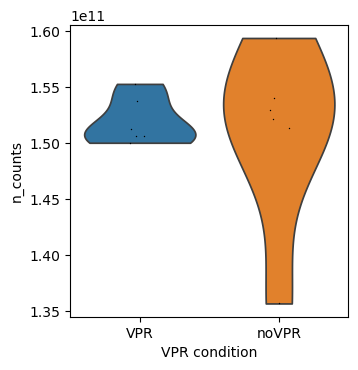

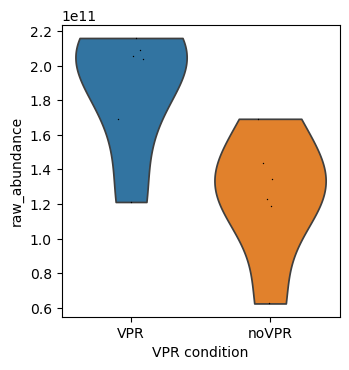

<Axes: xlabel='VPR_condition', ylabel='raw_abundance'>

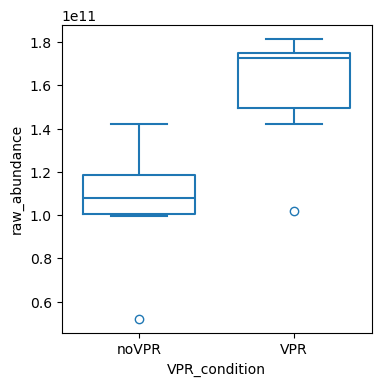

In [73]:
sc.pl.violin(adata, 'n_counts', groupby='VPR_condition')

sc.pl.violin(adata, 'raw_abundance', groupby='VPR_condition')

adata.obs['raw_abundance'] = np.sum(adata.layers['raw_counts_2'], axis=1).tolist()
sns.boxplot(data=adata.obs, x="VPR_condition", y="raw_abundance", order=['noVPR', 'VPR'], fill=False, gap=.1)

In [74]:
df = pd.DataFrame()
df['noVPR']=adata.obs['raw_abundance'][:6].tolist()
df['VPR']=adata.obs['raw_abundance'][6:].tolist()
df

,noVPR,VPR
0,1.126365e+11,1.421036e+11
1,1.421331e+11,1.719343e+11
2,5.218524e+10,1.020953e+11
3,1.031366e+11,1.756140e+11
4,9.980697e+10,1.733966e+11
5,1.206221e+11,1.816124e+11


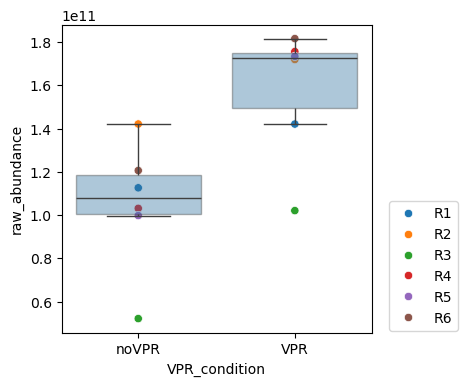

In [75]:
ax = sns.boxplot(data=adata.obs, x="VPR_condition", y="raw_abundance", order=['noVPR', 'VPR'],
                 showfliers=False, boxprops={'alpha': 0.4})
sns.scatterplot(data=adata.obs, x="VPR_condition", y="raw_abundance", hue='replicates',
              #hue_order=['R1', 'R2', 'R3', 'R4', 'R5', 'R6'],
              ax=ax)

plt.legend(bbox_to_anchor = [1.3, 0.45])
plt.savefig("boxplot_version1.png", bbox_inches='tight')
plt.show()

In [76]:
adata

AnnData object with n_obs × n_vars = 12 × 39620
    obs: 'VPR_condition', 'replicates', 'n_features', 'log_n_features', 'n_counts', 'log_n_counts', 'raw_abundance'
    var: 'Annotated Sequence', 'Modifications', 'Qvality PEP', 'Qvality q-value', '# Protein Groups', '# Proteins', '# PSMs', 'Master Protein Accessions', 'Positions in Master Proteins', 'Modifications in Master Proteins', '# Missed Cleavages', 'Theo. MH+ [Da]', 'Abundance Ratio: (VPR) / (noVPR)', 'gene_name', 'log_n_cells', 'n_samples', 'nb_peptides', 'nb_peptide_for_prot'
    uns: 'VPR_condition_colors'
    layers: 'raw_counts', 'raw_counts_2'

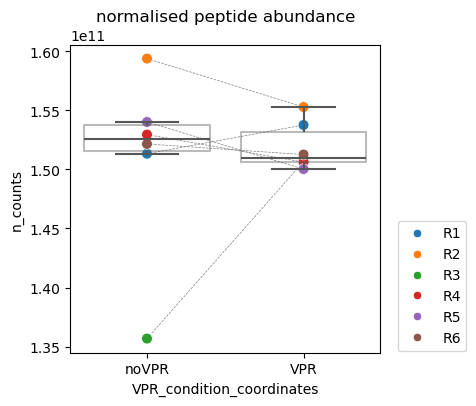

In [77]:
df_real = pd.DataFrame()
df_real['noVPR']=adata.obs[adata.obs['VPR_condition']=='noVPR']['n_counts'].tolist()
df_real['VPR']=adata.obs[adata.obs['VPR_condition']=='VPR']['n_counts'].tolist()

df_x_jitter = pd.DataFrame()
df_x_jitter['noVPR']= [0]*6
df_x_jitter['VPR']=[1]*6

adata.obs['VPR_condition_coordinates'] = [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1]

ax = sns.scatterplot(data=adata.obs, x="VPR_condition_coordinates", y="n_counts", hue='replicates')

sns.boxplot(data=adata.obs, x="VPR_condition", y="n_counts", order=['noVPR', 'VPR'], fill=False, color="#555755",
                 #color="#dee0de", linecolor="#137"
                 showfliers=False, boxprops={'alpha': 0.4},)

ax.collections[0].set_sizes([60]) 
#for idx in df.index:
#    ax.plot(df.loc[idx,['noVPR','VPR']], df.loc[idx,['noVPR','VPR']], color = 'grey', linewidth = 0.5, linestyle = '--', zorder=-1)
for idx in df_real.index:
    ax.plot(df_x_jitter.loc[idx,['noVPR','VPR']], df_real.loc[idx,['noVPR','VPR']], color = 'grey', linewidth = 0.5, linestyle = '--', zorder=-1)
    #ax.plot(df_x_jitter.loc[idx,['condition 3','condition 4']], df.loc[idx,['condition 3','condition 4']], color = 'grey', linewidth = 0.5, linestyle = '--', zorder=-1)

plt.legend(bbox_to_anchor = [1.3, 0.45])
plt.title('normalised peptide abundance')
plt.savefig("boxplot_version_normalise.png", bbox_inches='tight', dpi=800)
plt.savefig("boxplot_version_normalise.pdf", bbox_inches='tight', dpi=800)
plt.savefig("boxplot_version_normalise.svg", bbox_inches='tight', dpi=800)
plt.show()

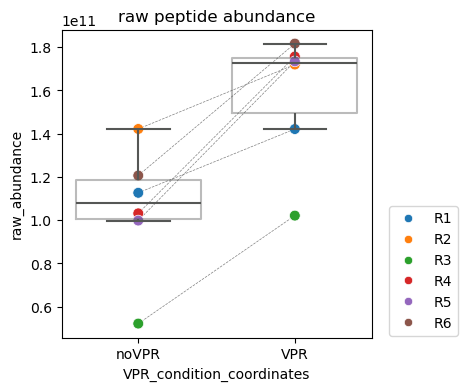

In [78]:
df_real = pd.DataFrame()
df_real['noVPR']=adata.obs[adata.obs['VPR_condition']=='noVPR']['raw_abundance'].tolist()
df_real['VPR']=adata.obs[adata.obs['VPR_condition']=='VPR']['raw_abundance'].tolist()

df_x_jitter = pd.DataFrame()
df_x_jitter['noVPR']= [0]*6
df_x_jitter['VPR']=[1]*6

adata.obs['VPR_condition_coordinates'] = [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1]

ax = sns.scatterplot(data=adata.obs, x="VPR_condition_coordinates", y="raw_abundance", hue='replicates')

sns.boxplot(data=adata.obs, x="VPR_condition", y="raw_abundance", order=['noVPR', 'VPR'], fill=False, color="#555755",
                 #color="#dee0de", linecolor="#137"
                 showfliers=False, boxprops={'alpha': 0.4},)

ax.collections[0].set_sizes([60]) 
#for idx in df.index:
#    ax.plot(df.loc[idx,['noVPR','VPR']], df.loc[idx,['noVPR','VPR']], color = 'grey', linewidth = 0.5, linestyle = '--', zorder=-1)
for idx in df_real.index:
    ax.plot(df_x_jitter.loc[idx,['noVPR','VPR']], df_real.loc[idx,['noVPR','VPR']], color = 'grey', linewidth = 0.5, linestyle = '--', zorder=-1)
    #ax.plot(df_x_jitter.loc[idx,['condition 3','condition 4']], df.loc[idx,['condition 3','condition 4']], color = 'grey', linewidth = 0.5, linestyle = '--', zorder=-1)

plt.legend(bbox_to_anchor = [1.3, 0.45])
plt.title('raw peptide abundance')
plt.savefig("boxplot_version1.png", bbox_inches='tight', dpi=800)
plt.savefig("boxplot_version1.pdf", bbox_inches='tight', dpi=800)
plt.savefig("boxplot_version1.svg", bbox_inches='tight', dpi=800)
plt.show()

In [79]:
# Welch test
VPR_abundance = adata.obs['raw_abundance'][:6]
noVPR_abundance = adata.obs['raw_abundance'][6:]
stats.ttest_ind(VPR_abundance, noVPR_abundance)

TtestResult(statistic=-3.013357115473192, pvalue=0.013042603953708161, df=10.0)

## THE FOLD CHANGE for each replicates! 

In [80]:
vpr_list = adata.obs['raw_abundance'][6:].tolist()
no_vpr_list = adata.obs['raw_abundance'][0:6].tolist()
vpr_ratio = [x/y for x,y in zip(vpr_list,no_vpr_list)]
vpr_ratio

[1.2616120753915847,
 1.2096715685866115,
 1.956401854872167,
 1.7027326575179664,
 1.7373194582839324,
 1.5056311820652775]

In [81]:
# mean fold change
np.mean(vpr_ratio)

1.5622281327862566

In [82]:
np.log2(vpr_ratio)

array([0.33526837, 0.2746154 , 0.96820274, 0.76785194, 0.79686306,
       0.59036841])

# Rank peptide ratios

In [83]:
len(set(adata.var['Master Protein Accessions']))

4060

In [84]:
## Make the second plot - ratio VPR noVPR per peptide

In [85]:
adata_vpr = adata[adata.obs['VPR_condition']=='VPR',:].copy()
adata_novpr = adata[adata.obs['VPR_condition']=='noVPR',:].copy()

adata_vpr.var['sum']=np.sum(adata_vpr.layers['raw_counts_2'], axis=0).tolist()
adata_vpr.var['mean']=np.mean(adata_vpr.layers['raw_counts_2'], axis=0).tolist()
adata_vpr.var['std']=np.std(adata_vpr.layers['raw_counts_2'], axis=0).tolist()

adata_novpr.var['sum']=np.sum(adata_novpr.layers['raw_counts_2'], axis=0).tolist()
adata_novpr.var['mean']=np.mean(adata_novpr.layers['raw_counts_2'], axis=0).tolist()
adata_novpr.var['std']=np.std(adata_novpr.layers['raw_counts_2'], axis=0).tolist()

adata_novpr.var['no_vpr_count'] = np.sum(adata_novpr.layers['raw_counts_2'], axis=0).tolist()
adata_novpr_zero = adata_novpr[:,adata_novpr.var['no_vpr_count']==0]

adata_vpr.var['no_vpr_count'] = adata_novpr.var['no_vpr_count']

adata_novpr_nozero = adata_novpr[:,adata_novpr.var['no_vpr_count']!=0]
adata_novpr_nozero

adata_vpr_nozero = adata_vpr[:,adata_vpr.var['no_vpr_count']!=0]
adata_vpr_nozero

#vpr_list = adata_novpr_nozero.var['mean'].tolist()
#no_vpr_list = adata_novpr_nozero.var['mean'].tolist()

vpr_list = adata_vpr.var['sum'].tolist()
no_vpr_list = adata_novpr_nozero.var['sum'].tolist()

ratio_norm_peptide =[x/y for x,y in zip(vpr_list,no_vpr_list)]
adata_vpr_nozero.var['ratio_vpr_novpr'] = ratio_norm_peptide
#ratio_norm_peptide

df = adata_vpr_nozero.var.copy()
df = df.sort_values('ratio_vpr_novpr')
df['ranking'] = range(0,len(df['ratio_vpr_novpr'].tolist()))


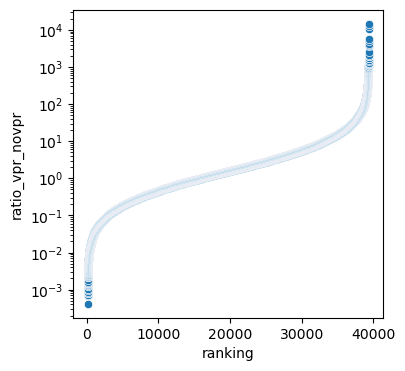

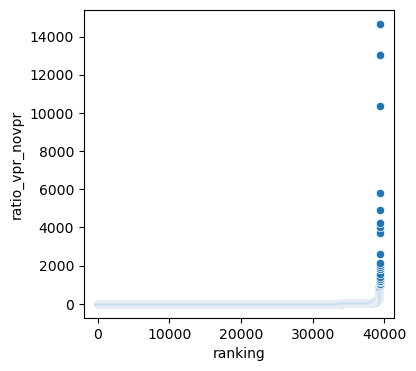

In [86]:
#peptide scatterplot
sns.scatterplot(df, x='ranking', y='ratio_vpr_novpr',)
plt.yscale('log')
plt.show()
#peptide scatterplot
sns.scatterplot(df, x='ranking', y='ratio_vpr_novpr',)
#plt.yscale('log')
plt.show()

# sum the 3 most abundant peptides per proteins

In [87]:
prt_list = []
prt_count = []
prt_sum = []
for protein in set(adata.var['Master Protein Accessions']):
    tmp_adata = adata[:,adata.var['Master Protein Accessions']==protein].copy()
    # Get the abundance of peptide
    top_coverage = np.sum(tmp_adata.X, axis=0).tolist()
    tmp_adata.var['filt_coverage']=top_coverage
    top_coverage.sort()
    #top_coverage

    if len(top_coverage)>3:
        tmp_adata=tmp_adata[:,tmp_adata.var['filt_coverage']>=top_coverage[-3]].copy()

    prt_count.append(np.mean(tmp_adata.X, axis=1).tolist())
    prt_sum.append(np.sum(tmp_adata.X, axis=1).tolist())
    prt_list.append(protein)
    
prt_count = np.array(prt_count).transpose()
prt_sum = np.array(prt_sum).transpose()
adata_prot = ad.AnnData(X=prt_sum)
adata_prot.obs = adata.obs.copy()
adata_prot.var_names = prt_list
adata_prot.layers['mean_peptides'] = prt_count

prt_count = np.array(prt_count)
prt_sum = np.array(prt_sum).transpose()

prt_list = []
prt_count = []
prt_sum = []
for protein in set(adata.var['Master Protein Accessions']):
    tmp_adata = adata[:,adata.var['Master Protein Accessions']==protein].copy()
    # Get the abundance of peptide
    top_coverage = np.sum(tmp_adata.X, axis=0).tolist()
    tmp_adata.var['filt_coverage']=top_coverage
    top_coverage.sort()
    #top_coverage

    if len(top_coverage)>3:
        tmp_adata=tmp_adata[:,tmp_adata.var['filt_coverage']>=top_coverage[-3]].copy()
    
    prt_count.append(np.mean(tmp_adata.layers['raw_counts_2'], axis=1).tolist())
    prt_sum.append(np.sum(tmp_adata.layers['raw_counts_2'], axis=1).tolist())
    prt_list.append(protein)
prt_count = np.array(prt_count).transpose()
prt_sum = np.array(prt_sum).transpose()
adata_prot.layers['raw_counts_2'] =prt_count
adata_prot.layers['sum_peptides_raw_counts_2'] = prt_sum

prt_list = []
prt_count = []
prt_sum = []
for protein in set(adata.var['Master Protein Accessions']):
    tmp_adata = adata[:,adata.var['Master Protein Accessions']==protein].copy()
    # Get the abundance of peptide
    top_coverage = np.sum(tmp_adata.X, axis=0).tolist()
    tmp_adata.var['filt_coverage']=top_coverage
    top_coverage.sort()
    #top_coverage

    if len(top_coverage)>3:
        tmp_adata=tmp_adata[:,tmp_adata.var['filt_coverage']>=top_coverage[-3]].copy()
    prt_count.append(np.mean(tmp_adata.layers['raw_counts'], axis=1).tolist())
    prt_sum.append(np.sum(tmp_adata.layers['raw_counts'], axis=1).tolist())
    prt_list.append(protein)
prt_count = np.array(prt_count).transpose()
prt_sum = np.array(prt_sum).transpose()
adata_prot.layers['raw_counts'] =prt_count
adata_prot.layers['sum_peptides_raw_counts'] = prt_sum

adata_prot

AnnData object with n_obs × n_vars = 12 × 4060
    obs: 'VPR_condition', 'replicates', 'n_features', 'log_n_features', 'n_counts', 'log_n_counts', 'raw_abundance', 'VPR_condition_coordinates'
    layers: 'mean_peptides', 'raw_counts_2', 'sum_peptides_raw_counts_2', 'raw_counts', 'sum_peptides_raw_counts'

## Make the second plot - ratio VPR noVPR per protein

In [88]:
adata_vpr = adata_prot[adata_prot.obs['VPR_condition']=='VPR',:].copy()
adata_novpr = adata_prot[adata_prot.obs['VPR_condition']=='noVPR',:].copy()

adata_vpr.var['mean']=np.mean(adata_vpr.layers['raw_counts_2'], axis=0).tolist()
adata_vpr.var['std']=np.std(adata_vpr.layers['raw_counts_2'], axis=0).tolist()
adata_vpr.var['var']=np.var(adata_vpr.layers['raw_counts_2'], axis=0).tolist()

adata_novpr.var['mean']=np.mean(adata_novpr.layers['raw_counts_2'], axis=0).tolist()
adata_novpr.var['std']=np.std(adata_novpr.layers['raw_counts_2'], axis=0).tolist()
adata_novpr.var['var']=np.var(adata_novpr.layers['raw_counts_2'], axis=0).tolist()

adata_novpr.var['no_vpr_count'] = np.sum(adata_novpr.layers['raw_counts_2'], axis=0).tolist()
adata_novpr_zero = adata_novpr[:,adata_novpr.var['no_vpr_count']==0]

adata_vpr.var['no_vpr_count'] = adata_novpr.var['no_vpr_count']
adata_novpr_nozero = adata_novpr[:,adata_novpr.var['no_vpr_count']!=0]
adata_novpr_nozero

adata_vpr_nozero = adata_vpr[:,adata_vpr.var['no_vpr_count']!=0]
adata_vpr_nozero

vpr_list = adata_vpr_nozero.var['mean'].tolist()
no_vpr_list = adata_novpr_nozero.var['mean'].tolist()

ratio_norm_peptide =[x/y for x,y in zip(vpr_list,no_vpr_list)]
adata_vpr_nozero.var['ratio_vpr_novpr'] = ratio_norm_peptide
#ratio_norm_peptide

df = adata_vpr_nozero.var.copy()
df = df.sort_values('ratio_vpr_novpr')
df['ranking'] = range(0,len(df['ratio_vpr_novpr'].tolist()))


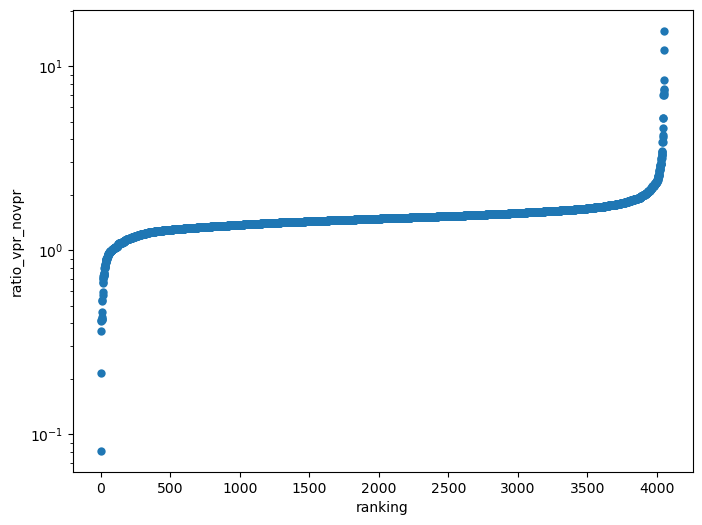

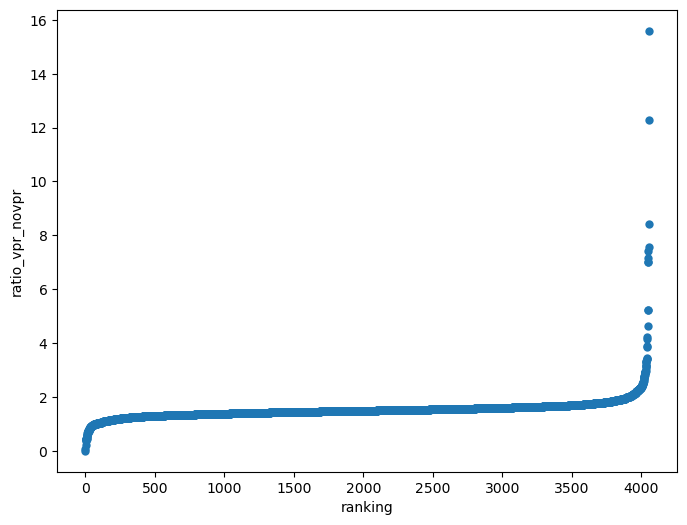

In [89]:
gene_name = []
missing_gene_names = []

for prot in df.index.tolist():
    
    if prot not in df_names.index.tolist():
        #print(prot)
        gene_name.append('missing protein name')
        missing_gene_names.append(prot)
    elif type(df_names.loc[prot]['gene name']) ==str:
        gene_name.append(df_names.loc[prot]['gene name'])
    else:
        gene_name.append(df_names.loc[prot]['gene name'].tolist()[0])
len(gene_name)
df['gene_name'] = gene_name

plt.figure(figsize=(8, 6))
sns.scatterplot(df, x='ranking', y='ratio_vpr_novpr', linewidth=0)
plt.yscale('log')
plt.savefig("ranked_ratio_1_log.svg", bbox_inches='tight', dpi=800)
plt.show()

plt.figure(figsize=(8, 6))
sns.scatterplot(df, x='ranking', y='ratio_vpr_novpr', linewidth=0)
plt.savefig("ranked_ratio_1_not_log.svg", bbox_inches='tight', dpi=800)
plt.show()

In [111]:
#df.to_csv('prot_abundance_ranked_ratios_Anna_mean_level_then_ratio_raw_counts.csv')
df_mean =pd.read_csv('prot_abundance_ranked_ratios_Anna_mean_level_then_ratio_raw_counts.csv')
df_mean['prot_id'] = df_mean['Unnamed: 0']
del df_mean['Unnamed: 0']
df_mean

,mean,std,var,no_vpr_count,ratio_vpr_novpr,ranking,gene_name,prot_id
0,0.000000e+00,0.000000e+00,0.000000e+00,1.665264e+06,0.000000,0,Ncs1,Q8BNY6
1,1.909676e+04,4.270166e+04,1.823432e+09,1.408608e+06,0.081343,1,Nle1,Q8VEJ4
2,1.057920e+06,2.013093e+05,4.052542e+10,2.960913e+07,0.214377,2,Acaca,Q5SWU9
3,1.012774e+05,1.545007e+05,2.387045e+10,1.671073e+06,0.363637,3,AU022252,Q5EBG8
4,6.143957e+04,1.373831e+05,1.887411e+10,8.953031e+05,0.411746,4,Krt19,P19001
...,...,...,...,...,...,...,...,...
4051,1.464769e+06,1.115003e+06,1.243231e+12,1.187520e+06,7.400812,4051,Cog4,Q8R1U1
4052,4.922813e+05,4.591067e+04,2.107790e+09,3.908515e+05,7.557058,4052,Irf3,P70671
4053,1.134956e+05,8.736711e+04,7.633012e+09,8.096927e+04,8.410272,4053,Pla2g12a,Q9EPR2
4054,4.361853e+05,2.067696e+05,4.275366e+10,2.133417e+05,12.267227,4054,Pdk2,Q9JK42


# plot all 6 replicates etc

In [112]:
array = adata_vpr_nozero.layers['raw_counts_2']/adata_novpr_nozero.layers['raw_counts_2']
df = pd.DataFrame(array)
df.columns = adata_vpr_nozero.var_names.tolist()

mean_ratios = []
std_ratios = []
nb_replicates = []
for column in df.columns.tolist():
    keep_value = []
    line = df[column].tolist()
    for element in line: 
        if np.isinf(element)==False and np.isnan(element)==False and element!=0:
            keep_value.append(element)
    mean_ratios.append(np.mean(keep_value))
    std_ratios.append(np.std(keep_value))
    nb_replicates.append(len(keep_value))


df = df.transpose()
df['std_of_ratio'] = std_ratios
df['mean_of_ratio'] = mean_ratios
df['nb_replicates_retained'] = nb_replicates


df=df[df['nb_replicates_retained']>2]
df

,0,1,2,3,4,5,std_of_ratio,mean_of_ratio,nb_replicates_retained
P42225,1.308376,1.203725,1.244211,1.198728,1.816313,1.494519,0.220209,1.377645,6
Q8CCM6,1.014983,1.338036,1.236160,1.817396,1.260252,1.319980,0.241736,1.331134,6
P28659,1.766259,1.271894,2.525086,1.814015,2.052515,1.570464,0.390672,1.833372,6
O08734,0.904587,2.679664,0.539003,2.617373,3.388091,1.559936,1.023216,1.948109,6
Q8BRT1,1.609923,1.446120,1.294780,1.839247,2.321346,1.506818,0.335173,1.669706,6
...,...,...,...,...,...,...,...,...,...
O54916,1.369769,0.887538,1.343339,1.342699,1.453093,1.411682,0.189118,1.301353,6
Q9D0R2,1.292726,1.148530,1.128003,1.596675,1.756941,1.459612,0.230332,1.397081,6
Q8BQ30,1.223819,1.355423,2.835866,1.639762,1.674330,1.455069,0.532277,1.697378,6
Q8CGZ0,1.134265,1.171696,3.258691,1.656347,1.608012,1.410515,0.721409,1.706588,6


In [113]:
df_mean.index = df_mean['prot_id']
tmp_df = df_mean[['ranking', 'ratio_vpr_novpr', 'gene_name']]
df = df.merge(tmp_df, how='left', left_index=True, right_index=True)
#df = pd.concat([df, tmp_df], axis=1)
df = df.sort_values('mean_of_ratio')
df['ranking_mean_of_ratio'] = list(range(1,1+len(df['mean_of_ratio'].tolist())))
df

,0,1,2,3,4,5,std_of_ratio,mean_of_ratio,nb_replicates_retained,ranking,ratio_vpr_novpr,gene_name,ranking_mean_of_ratio
Q8C569,0.299592,inf,0.312836,0.289542,inf,inf,0.009540,0.300657,3,24,0.748239,Fam118b,1
Q9CPX7,0.070183,0.549266,0.056160,0.821311,0.098892,0.846699,0.345614,0.407085,6,8,0.424981,Mrps16,2
Q9CYL5,0.987182,0.461140,0.853885,0.512095,0.695747,0.501708,0.196617,0.668626,6,15,0.661913,Glipr2,3
Q8R151,1.028258,0.455066,0.908373,0.575431,0.882094,0.452502,0.230713,0.716954,6,18,0.705265,Znfx1,4
Q9JJA2,1.080554,0.522833,0.543091,0.521122,1.206114,0.518388,0.293204,0.732017,6,17,0.701428,Cog8,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q8BWZ3,5.599807,8.418576,2.609290,10.533333,8.340180,8.252120,2.535981,7.292218,6,4048,7.016343,Naa25,4017
Q8R1U1,11.393108,1.876927,1.286633,6.940792,24.803503,7.001542,7.893721,8.883751,6,4051,7.400812,Cog4,4018
Q9CQ40,1.366928,1.082842,50.057086,1.420497,1.619592,1.702125,18.120193,9.541512,6,3114,1.610449,Mrpl49,4019
Q01065,0.563108,0.676586,72.244235,0.989754,0.917841,0.953322,26.618642,12.724141,6,66,0.982159,Pde1b,4020


In [114]:
df2 = pd.DataFrame()
df2['ratio']=df[0]
df2 = df2.sort_values('ratio')
df2['ranking']=df['ranking'].tolist()
df2['prot']=df.index.tolist()
df2['sample']  = ['rep 1']*len(df2['ratio'].tolist())
df2['mean_of_ratio'] = df['mean_of_ratio'].tolist()
df2['std_of_ratio'] = df['std_of_ratio'].tolist()
df2['ranking_mean_of_ratio'] = df['ranking_mean_of_ratio'].tolist()

df3 = pd.DataFrame()
df3['ratio']=df[1]
df3['sample']  = ['rep 2']*len(df3['ratio'].tolist())
df3['ranking']=df['ranking'].tolist()
df3['prot']=df.index.tolist()
df3['mean_of_ratio'] = df['mean_of_ratio'].tolist()
df3['std_of_ratio'] = df['std_of_ratio'].tolist()
df3['ranking_mean_of_ratio'] = df['ranking_mean_of_ratio'].tolist()

result = pd.concat([df2, df3])
#result['prot'] = result.index.tolist()
result.index =  range(0,len(result['ratio'].tolist()))
#result


################

df3 = pd.DataFrame()
df3['ratio']=df[2]
#df3 = df3.sort_values('ratio')
df3['sample']  = ['rep 3']*len(df3['ratio'].tolist())
df3['ranking']=df['ranking'].tolist()
df3['prot']=df.index.tolist()
df3['mean_of_ratio'] = df['mean_of_ratio'].tolist()
df3['std_of_ratio'] = df['std_of_ratio'].tolist()
df3['ranking_mean_of_ratio'] = df['ranking_mean_of_ratio'].tolist()

result = pd.concat([result, df3])
#result['prot'] = result.index.tolist()
result.index =  range(0,len(result['ratio'].tolist()))
result

################

df3 = pd.DataFrame()
df3['ratio']=df[3]
#df3 = df3.sort_values('ratio')
#df3['ranking'] = df_mean['ranking'].tolist()
df3['sample']  = ['rep 4']*len(df3['ratio'].tolist())
df3['ranking']=df['ranking'].tolist()
df3['prot']=df.index.tolist()
df3['mean_of_ratio'] = df['mean_of_ratio'].tolist()
df3['std_of_ratio'] = df['std_of_ratio'].tolist()
df3['ranking_mean_of_ratio'] = df['ranking_mean_of_ratio'].tolist()

result = pd.concat([result, df3])
#result['prot'] = result.index.tolist()
result.index =  range(0,len(result['ratio'].tolist()))

################

df3 = pd.DataFrame()
df3['ratio']=df[4]
#df3 = df3.sort_values('ratio')
#df3['ranking'] = df_mean['ranking'].tolist()
df3['ranking']=df['ranking'].tolist()
df3['prot']=df.index.tolist()
df3['sample']  = ['rep 5']*len(df3['ratio'].tolist())
df3['mean_of_ratio'] = df['mean_of_ratio'].tolist()
df3['std_of_ratio'] = df['std_of_ratio'].tolist()
df3['ranking_mean_of_ratio'] = df['ranking_mean_of_ratio'].tolist()

result = pd.concat([result, df3])
#result['prot'] = result.index.tolist()
result.index =  range(0,len(result['ratio'].tolist()))

################

df3 = pd.DataFrame()
df3['ratio']=df[5]
#df3 = df3.sort_values('ratio')
#df3['ranking'] = df_mean['ranking'].tolist()
df3['sample']  = ['rep 6']*len(df3['ratio'].tolist())
df3['ranking']=df['ranking'].tolist()
df3['prot']=df.index.tolist()
df3['mean_of_ratio'] = df['mean_of_ratio'].tolist()
df3['std_of_ratio'] = df['std_of_ratio'].tolist()
df3['ranking_mean_of_ratio'] = df['ranking_mean_of_ratio'].tolist()

result = pd.concat([result, df3])
#result['prot'] = result.index.tolist()
result.index =  range(0,len(result['ratio'].tolist()))
result = result.sort_values(['ranking','sample'])
result

,ratio,ranking,prot,sample,mean_of_ratio,std_of_ratio,ranking_mean_of_ratio
397,0.969480,2,Q5SWU9,rep 1,1.334229,0.672416,398
4418,0.042814,2,Q5SWU9,rep 2,1.334229,0.672416,398
8439,1.091801,2,Q5SWU9,rep 3,1.334229,0.672416,398
12460,1.959392,2,Q5SWU9,rep 4,1.334229,0.672416,398
16481,2.087367,2,Q5SWU9,rep 5,1.334229,0.672416,398
...,...,...,...,...,...,...,...
8038,1.876927,4051,Q8R1U1,rep 2,8.883751,7.893721,4018
12059,1.286633,4051,Q8R1U1,rep 3,8.883751,7.893721,4018
16080,6.940792,4051,Q8R1U1,rep 4,8.883751,7.893721,4018
20101,24.803503,4051,Q8R1U1,rep 5,8.883751,7.893721,4018


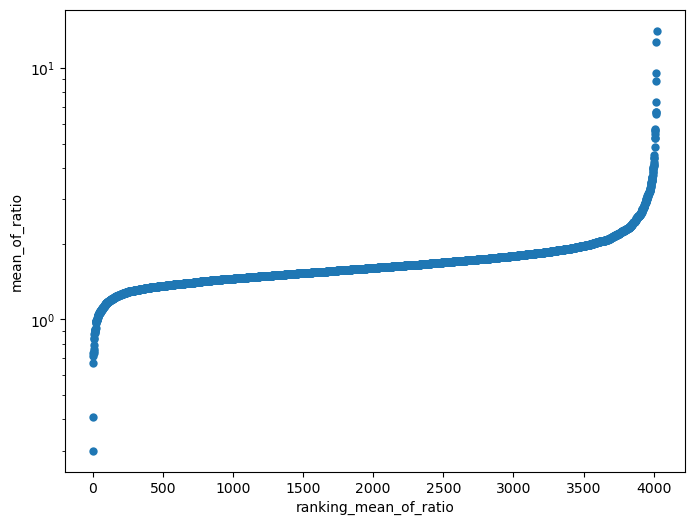

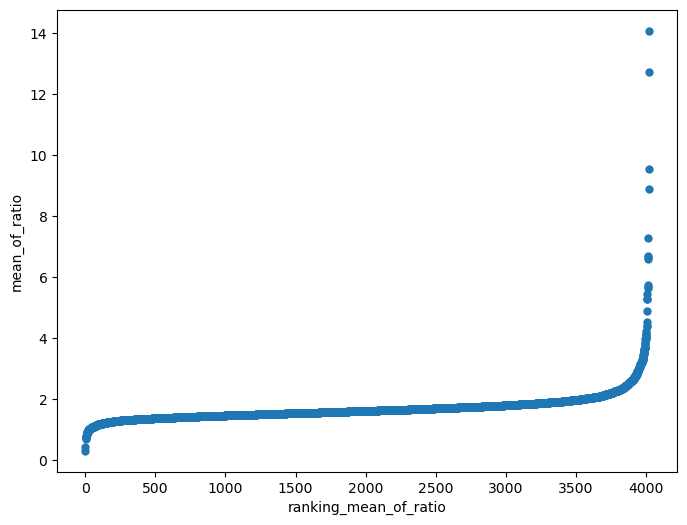

In [115]:
plt.figure(figsize=(8, 6))
sns.scatterplot(df, x='ranking_mean_of_ratio', y='mean_of_ratio', linewidth=0)
#sns.scatterplot(df, x='ranking', y='std',)
plt.yscale('log')

plt.savefig("ranked_ratio_2_log.svg", bbox_inches='tight', dpi=800)
plt.show()

plt.figure(figsize=(8, 6))
sns.scatterplot(df, x='ranking_mean_of_ratio', y='mean_of_ratio', linewidth=0)
#sns.scatterplot(df, x='ranking', y='std',)
#plt.yscale('log')
plt.savefig("ranked_ratio_2_not_log.svg", bbox_inches='tight', dpi=800)
plt.show()

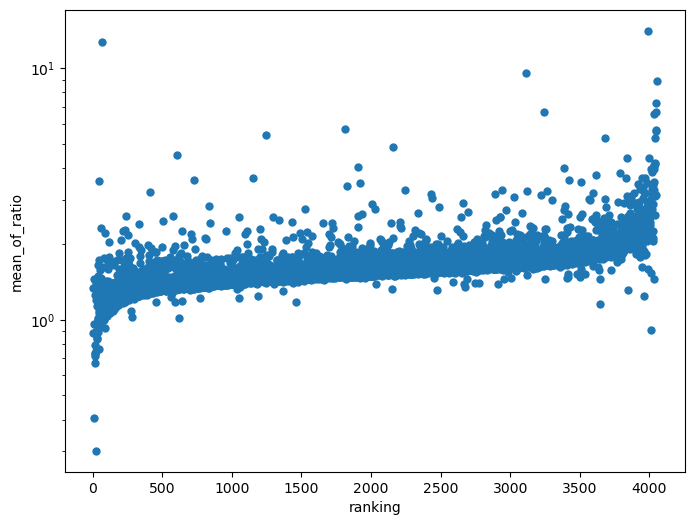

In [116]:
plt.figure(figsize=(8, 6))
sns.scatterplot(df, x='ranking', y='mean_of_ratio', linewidth=0)
#sns.scatterplot(df, x='ranking', y='std',)
plt.yscale('log')

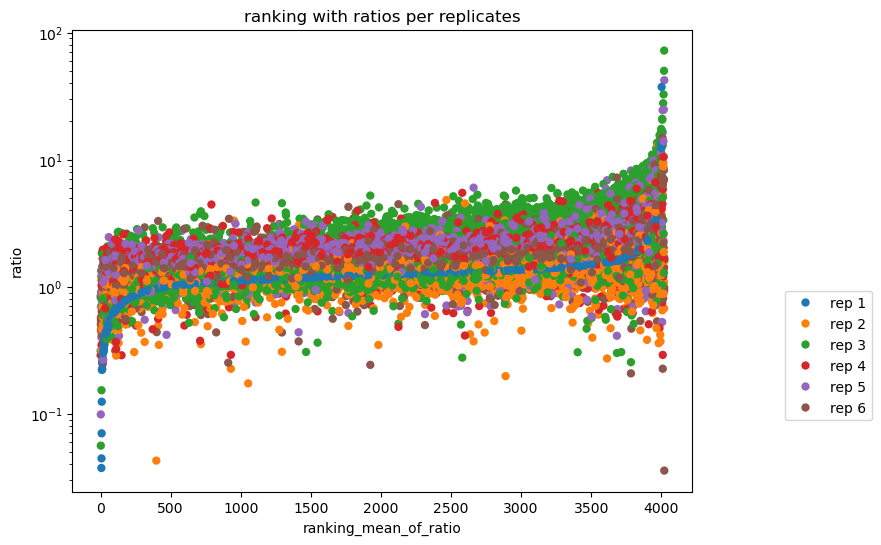

In [128]:
plt.figure(figsize=(8, 6))
sns.scatterplot(result, x='ranking_mean_of_ratio', y='ratio', hue='sample', linewidth=0)
#sns.scatterplot(df, x='ranking', y='std',)
plt.yscale('log')


plt.legend(bbox_to_anchor = [1.3, 0.45])
plt.title('ranking with ratios per replicates')
plt.savefig("ranking_per_replicate.svg", bbox_inches='tight', dpi=800)


In [118]:
result

,ratio,ranking,prot,sample,mean_of_ratio,std_of_ratio,ranking_mean_of_ratio
397,0.969480,2,Q5SWU9,rep 1,1.334229,0.672416,398
4418,0.042814,2,Q5SWU9,rep 2,1.334229,0.672416,398
8439,1.091801,2,Q5SWU9,rep 3,1.334229,0.672416,398
12460,1.959392,2,Q5SWU9,rep 4,1.334229,0.672416,398
16481,2.087367,2,Q5SWU9,rep 5,1.334229,0.672416,398
...,...,...,...,...,...,...,...
8038,1.876927,4051,Q8R1U1,rep 2,8.883751,7.893721,4018
12059,1.286633,4051,Q8R1U1,rep 3,8.883751,7.893721,4018
16080,6.940792,4051,Q8R1U1,rep 4,8.883751,7.893721,4018
20101,24.803503,4051,Q8R1U1,rep 5,8.883751,7.893721,4018


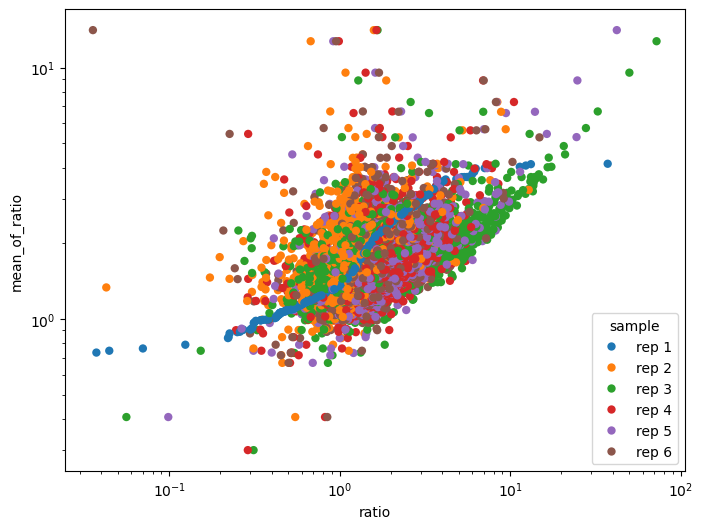

In [119]:
plt.figure(figsize=(8, 6))
sns.scatterplot(result, x='ratio', y='mean_of_ratio', hue='sample', linewidth=0)
#sns.scatterplot(df, x='ranking', y='std',)
plt.yscale('log')
plt.xscale('log')

<Axes: xlabel='ratio', ylabel='mean_of_ratio'>

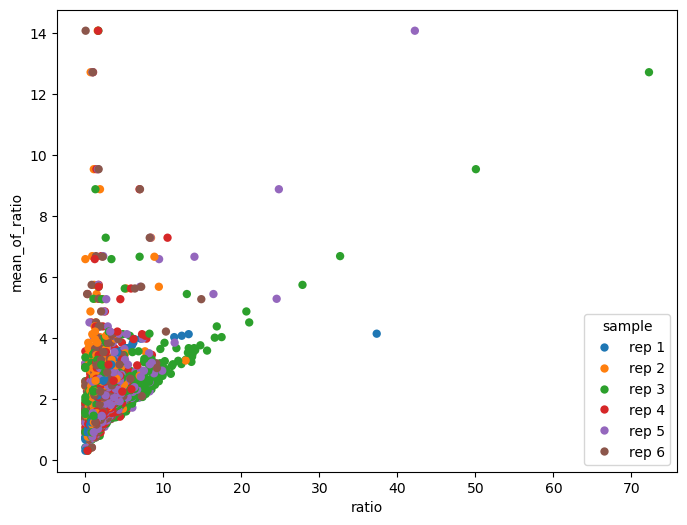

In [120]:
plt.figure(figsize=(8, 6))
sns.scatterplot(result, x='ratio', y='mean_of_ratio', hue='sample', linewidth=0)
#sns.scatterplot(df, x='ranking', y='std',)
#plt.yscale('log')
#plt.xscale('log')

In [121]:
result

,ratio,ranking,prot,sample,mean_of_ratio,std_of_ratio,ranking_mean_of_ratio
397,0.969480,2,Q5SWU9,rep 1,1.334229,0.672416,398
4418,0.042814,2,Q5SWU9,rep 2,1.334229,0.672416,398
8439,1.091801,2,Q5SWU9,rep 3,1.334229,0.672416,398
12460,1.959392,2,Q5SWU9,rep 4,1.334229,0.672416,398
16481,2.087367,2,Q5SWU9,rep 5,1.334229,0.672416,398
...,...,...,...,...,...,...,...
8038,1.876927,4051,Q8R1U1,rep 2,8.883751,7.893721,4018
12059,1.286633,4051,Q8R1U1,rep 3,8.883751,7.893721,4018
16080,6.940792,4051,Q8R1U1,rep 4,8.883751,7.893721,4018
20101,24.803503,4051,Q8R1U1,rep 5,8.883751,7.893721,4018


<Axes: xlabel='std_of_ratio', ylabel='mean_of_ratio'>

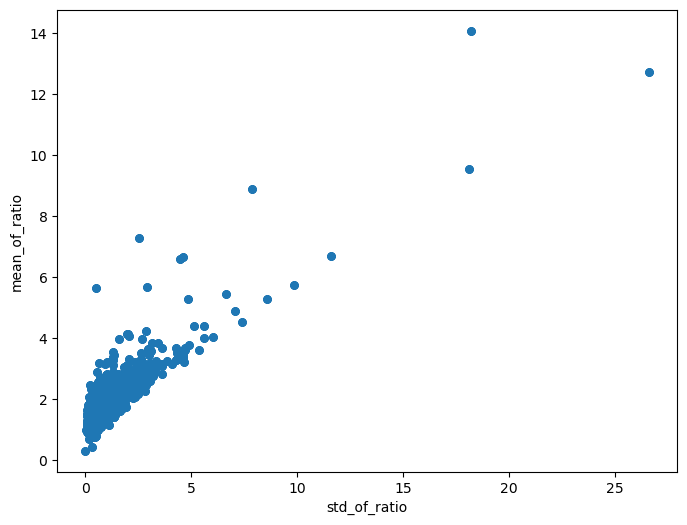

In [122]:
plt.figure(figsize=(8, 6))

sns.scatterplot(result, x='std_of_ratio', y='mean_of_ratio', linewidth=0)
#sns.scatterplot(df, x='ranking', y='std',)
#plt.yscale('log')
#plt.xscale('log')

In [123]:
result

,ratio,ranking,prot,sample,mean_of_ratio,std_of_ratio,ranking_mean_of_ratio
397,0.969480,2,Q5SWU9,rep 1,1.334229,0.672416,398
4418,0.042814,2,Q5SWU9,rep 2,1.334229,0.672416,398
8439,1.091801,2,Q5SWU9,rep 3,1.334229,0.672416,398
12460,1.959392,2,Q5SWU9,rep 4,1.334229,0.672416,398
16481,2.087367,2,Q5SWU9,rep 5,1.334229,0.672416,398
...,...,...,...,...,...,...,...
8038,1.876927,4051,Q8R1U1,rep 2,8.883751,7.893721,4018
12059,1.286633,4051,Q8R1U1,rep 3,8.883751,7.893721,4018
16080,6.940792,4051,Q8R1U1,rep 4,8.883751,7.893721,4018
20101,24.803503,4051,Q8R1U1,rep 5,8.883751,7.893721,4018


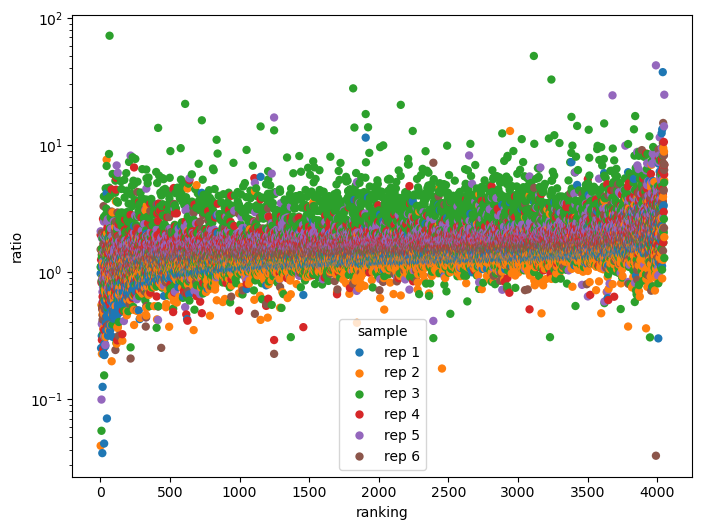

In [124]:
plt.figure(figsize=(8, 6))
sns.scatterplot(result, x='ranking', y='ratio', hue='sample', linewidth=0)
#sns.scatterplot(df, x='ranking', y='std',)
plt.yscale('log')

In [126]:
df.to_csv('final_proteomic_ranking_2_options_sum_top3_peptides.csv')

# Use plotly 

In [129]:
import plotly.graph_objs as go
import pandas as pd
#!pip install plotly

import plotly.io as pio
pio.renderers.default = 'notebook'

import plotly.offline as pyo
pyo.init_notebook_mode(connected=True)


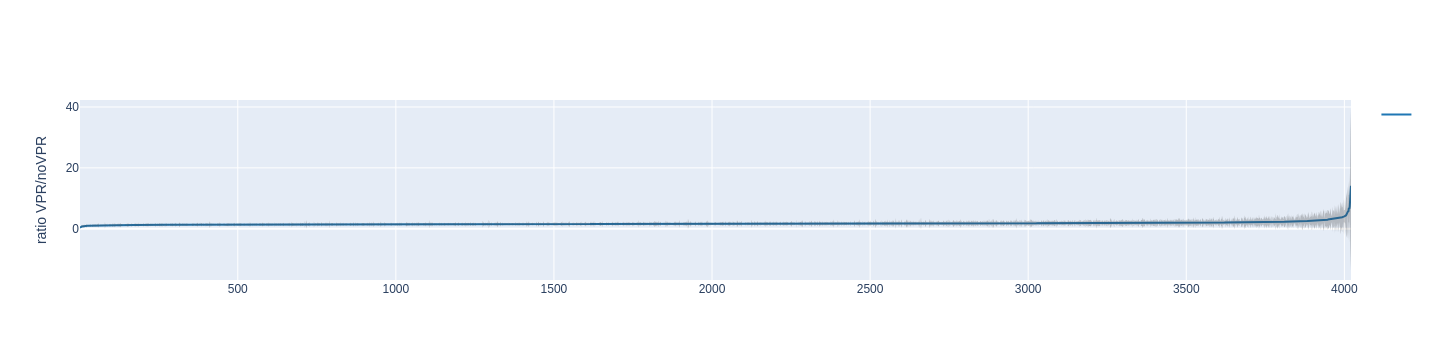

In [142]:
fig = go.Figure([
    go.Scatter(
        name='',
        x=df['ranking_mean_of_ratio'],
        y=df['mean_of_ratio'],
        mode='lines',
        line=dict(color='rgb(31, 119, 180)')
    ),
    go.Scatter(
        name='Upper Bound',
        x=df['ranking_mean_of_ratio'],
        y=df['mean_of_ratio']+df['std_of_ratio'],
        mode='lines',
        marker=dict(color="#444"),
        line=dict(width=0),
        showlegend=False
    ),
    go.Scatter(
        name='Lower Bound',
        x=df['ranking_mean_of_ratio'],
        y=df['mean_of_ratio']-df['std_of_ratio'],
        marker=dict(color="#444"),
        line=dict(width=0),
        mode='lines',
        fillcolor='rgba(68, 68, 68, 0.3)',
        fill='tonexty',
        showlegend=False
    )
])
fig.update_layout(
    yaxis_title='ratio VPR/noVPR',
    title='',
    hovermode="x"
)
#fig.update_yaxes(type="log")
#fig.write_html("./ranking_with_std_dev_of_ratios_not_log.html")
fig.write_image("./ranking_with_std_dev_of_ratios_not_log.svg")
fig.show()




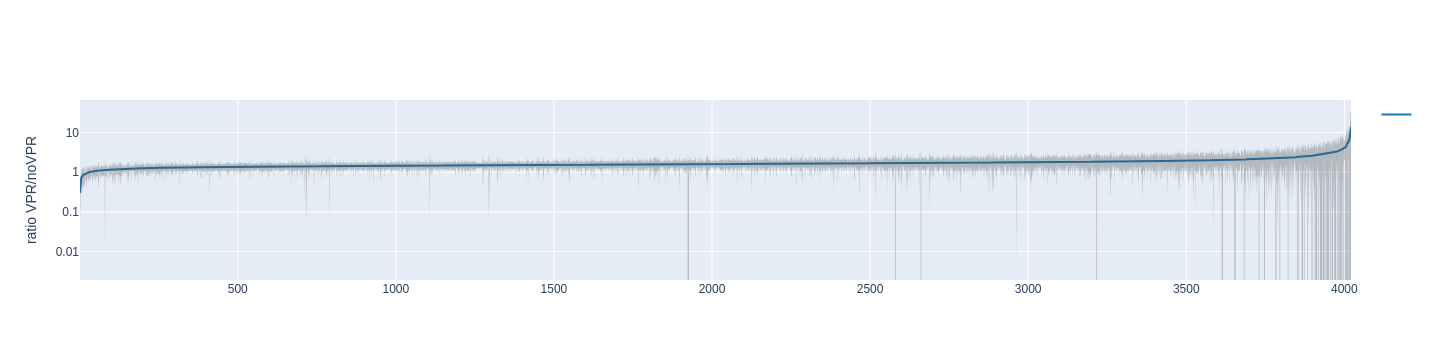

In [141]:
fig = go.Figure([
    go.Scatter(
        name='',
        x=df['ranking_mean_of_ratio'],
        y=df['mean_of_ratio'],
        mode='lines',
        line=dict(color='rgb(31, 119, 180)')
    ),
    go.Scatter(
        name='Upper Bound',
        x=df['ranking_mean_of_ratio'],
        y=df['mean_of_ratio']+df['std_of_ratio'],
        mode='lines',
        marker=dict(color="#444"),
        line=dict(width=0),
        showlegend=False
    ),
    go.Scatter(
        name='Lower Bound',
        x=df['ranking_mean_of_ratio'],
        y=df['mean_of_ratio']-df['std_of_ratio'],
        marker=dict(color="#444"),
        line=dict(width=0),
        mode='lines',
        fillcolor='rgba(68, 68, 68, 0.3)',
        fill='tonexty',
        showlegend=False
    )
])
fig.update_layout(
    yaxis_title='ratio VPR/noVPR',
    title='',
    hovermode="x"
)
fig.update_yaxes(type="log")

fig.write_image("./ranking_with_std_dev_of_ratios_log.svg")
fig.show()


